In [1]:
import numpy as np
#import keras
from keras import layers
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from autograd import grad
import autograd.numpy as np

import os

import tensorflow as tf
from tensorflow import keras


## Table of Content

- Help functions
- Data generations
- NN model
- HMC sampling
- plot functions

All graphs generated in the main notebook can be produced through running some combinations of codes here, with or without slight modifications.

In [2]:
def plot_graphs(samples,model):

  #create linespace
  x_linespace = np.linspace(-6, 6, 100)
  y_linespace = np.linspace(-6, 6, 100)
  dd_linespace = [[a, b] for a in x_linespace for b in y_linespace] 
  df_linespace = pd.DataFrame(dd_linespace,columns = ['x','y'])

  #construct feature space
  intermediate_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer(index = 2).output)


  linespace_output = np.array(intermediate_layer_model(df_linespace[['x','y']].values))
  linespace_withc = np.hstack((linespace_output,np.ones((linespace_output.shape[0],1),dtype = linespace_output.dtype)))

  #predict label for each point on linespace
  rand_samples = samples
  all_preds = []
  for W in rand_samples:
    V = softmax1(linespace_withc @ np.array(W).reshape((-1,nc)))
    all_preds.append(V)

  #assign predicted labels
  df_linespace['label'] = np.argmax(np.mean(all_preds,axis = 0),axis = 1)

  #assign uncertainty (using variance)
  mean_label = df_linespace['label']
  varss = np.var(all_preds,axis = 0)
  df_linespace['var']= [varss[i][mean_label[i]] for i in range(len(varss))]

  plt.figure(figsize = (16,8))
  plt.subplot(1,2,1)
  plottt = df_linespace.pivot("x","y", "label")
  plt.imshow(np.flip(plottt.values),origin = 'lower')
  plt.title('Classifications')

  plt.subplot(1,2,2)
  plottt = df_linespace.pivot("x","y", "var")
  plt.imshow(np.flip(plottt.values),origin = 'lower')
  plt.title('Uncertainty')


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(12, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def NN(data, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(data[['x','y']], data['label'], test_size=0.3, 
                                                        stratify = data['label'], random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 
    

## 1. Regular Data


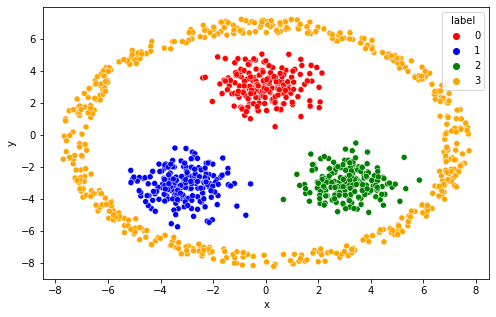

In [124]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)


np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label=3))
df1a_ood = df1a.append(df1a_ood, ignore_index=True)

plt.figure(figsize=[8,5])
#col = [str(a) for a in df1a['label']]
sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]); # , hue="label"


## 2. OOD-semicircle

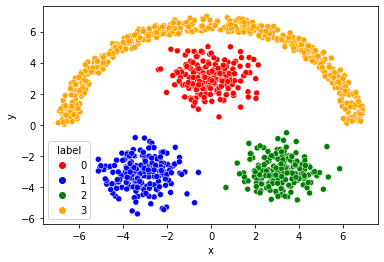

In [4]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

np.random.seed(0)
r = 6 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

df1b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1b_ood = pd.DataFrame(dict(x=x1, y=x2, label=3))
df1b = df1b.append(df1b_ood, ignore_index=True)
df1a_ood = df1b.copy()
sns.scatterplot(data=df1b, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);



## 2.5  Incomplete OOD (w/ holes)

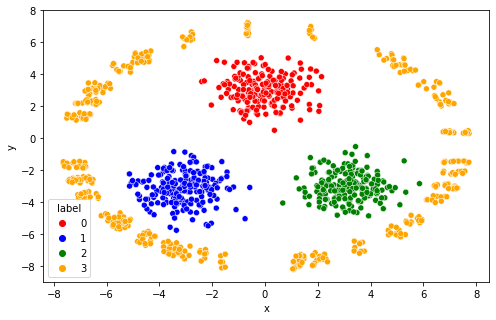

In [5]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 3], [-3, -3], [3, -3]], 
                           cluster_std=0.9, 
                           n_features=2, 
                           random_state=0)

np.random.seed(0)
r = 6.8 # radius
x1, x2 = [], []
angles = np.random.uniform(0,2 * np.pi, 50)

for _ in range(500):
    # random angle
    angle = np.random.choice(angles)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-.5+(r + random.random())*np.sin(angle))

df1c = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1c_ood = pd.DataFrame(dict(x=x1, y=x2, label=3)).sample(500, random_state = 0)
df1a = df1c.copy()
df1a_ood = df1c.append(df1c_ood, ignore_index=True)

plt.figure(figsize=[8,5])
sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);



## 3. Far-away OOD ring

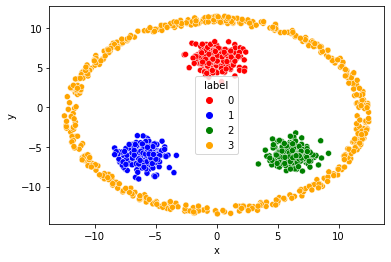

In [38]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

np.random.seed(0)
r = 11.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append(-1+(r + random.random())*np.sin(angle))

df2a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2a_ood = pd.DataFrame(dict(x=x1, y=x2, label=3))
df1a = df2a.copy()
df2a = df2a.append(df2a_ood, ignore_index=True)
df1a_ood = df2a.copy()
sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);


## 4. 3 OOD boundaries

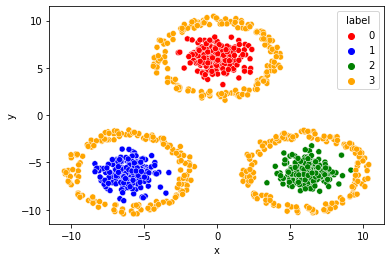

In [54]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 6], [-6, -6], [6, -6]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)
np.random.seed(42)
r = 3.5 # radius
cx1, cx2, cx3 = 0, -6, 6
cy1, cy2, cy3 = 6, -6, -6
x1, x2 = [], []
for _ in range(500//3):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(cx1 + (r + random.random())*np.cos(angle))
    x1.append(cx2 + (r + random.random())*np.cos(angle))
    x1.append(cx3 + (r + random.random())*np.cos(angle))
    x2.append(cy1 + (r + random.random())*np.sin(angle))
    x2.append(cy2 + (r + random.random())*np.sin(angle))
    x2.append(cy3 + (r + random.random())*np.sin(angle))

df2b = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df2b_ood = pd.DataFrame(dict(x=x1, y=x2, label=3))
df1a = df2b.copy()
df2b = df2b.append(df2b_ood, ignore_index=True)
df1a_ood = df2b.copy()

sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);


## 5. Not well seperated ring

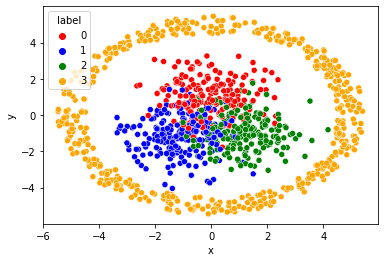

In [66]:
X, y = datasets.make_blobs(n_samples=[200,200,200], 
                           centers=[[0, 1], [-1, -1], [1, -1]], 
                           cluster_std=1, 
                           n_features=2, 
                           random_state=0)

np.random.seed(42)
r = 4.5 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append((r + random.random())*np.cos(angle))
    x2.append((r + random.random())*np.sin(angle))

df3 = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df3_ood = pd.DataFrame(dict(x=x1, y=x2, label=3))
df1a = df3.copy()
df3 = df3.append(df3_ood, ignore_index=True)
df1a_ood = df3.copy()

sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "green", "orange"]);


## 6. Well-Seperated by non-linear boundary

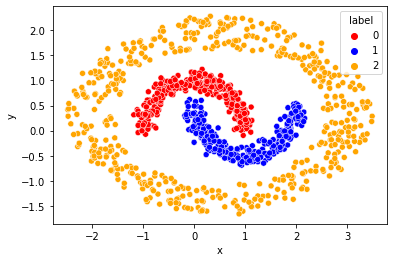

In [100]:
X, y = datasets.make_moons(n_samples=600, shuffle=True, noise=0.1, random_state=0)

# generate OOD
np.random.seed(0)
r = 2 # radius
x1, x2 = [], []
for _ in range(500):
    # random angle
    angle = np.random.uniform(0,2 * np.pi)
    x1.append(.5+(r + random.random())*np.cos(angle))
    x2.append(.3+(r + random.random())/1.5*np.sin(angle))

df1a = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
df1a_ood = pd.DataFrame(dict(x=x1, y=x2, label=2))
df1a_ood = df1a.append(df1a_ood, ignore_index=True)

sns.scatterplot(data=df1a_ood, x="x", y="y", hue="label", palette=["red", "blue", "orange"]);




## Model

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(12, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def NN(data, input_shape, nc, batch_size, epochs, loss):
    # separate data
    x_train, x_test, y_train, y_test = train_test_split(data[['x','y']], data['label'], test_size=0.3, 
                                                        stratify = data['label'], random_state=0)
    x_train = np.array(x_train)
    y_train = np.array(pd.get_dummies(y_train))
    x_test = np.array(x_test)
    y_test = np.array(pd.get_dummies(y_test))
    print("Shape of data: ", x_train.shape,y_train.shape, x_test.shape,y_test.shape)
    # train the model  
    batch_size = batch_size
    epochs = epochs
    
    model = make_model(input_shape=input_shape, num_classes=nc)
    model.compile(loss = loss, optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    # evaluation 
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    pred = model.predict(x_test)
    print(pred.shape)
    auc = roc_auc_score(y_test, pred)
    print("AUC: ", auc)
    return model 
    

## BaCoun

In [8]:
nc = 3

model = NN(df1a_ood, 2, nc+1 , 32, 50, "categorical_crossentropy")

Shape of data:  (770, 2) (770, 4) (330, 2) (330, 4)
Epoch 1/50
22/22 [==============================] - 0s 8ms/step - loss: 1.2235 - accuracy: 0.5758 - val_loss: 1.0095 - val_accuracy: 0.6753
Epoch 2/50
22/22 [==============================] - 0s 2ms/step - loss: 0.8411 - accuracy: 0.7215 - val_loss: 0.6278 - val_accuracy: 0.6883
Epoch 3/50
22/22 [==============================] - 0s 2ms/step - loss: 0.6021 - accuracy: 0.7850 - val_loss: 0.4822 - val_accuracy: 0.8182
Epoch 4/50
22/22 [==============================] - 0s 2ms/step - loss: 0.5157 - accuracy: 0.8009 - val_loss: 0.4750 - val_accuracy: 0.7922
Epoch 5/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.8427 - val_loss: 0.4234 - val_accuracy: 0.7792
Epoch 6/50
22/22 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8615 - val_loss: 0.4102 - val_accuracy: 0.8182
Epoch 7/50
22/22 [==============================] - 0s 2ms/step - loss: 0.3929 - accuracy: 0.8557 - val_loss

In [9]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(index = 4).output) #changed
# feature map
intermediate_output = np.array(intermediate_layer_model(df1a[['x','y']].values))

In [10]:
np.shape(intermediate_output)

(600, 12)

In [11]:
#nc = 3 # 3 classes
D = nc * (intermediate_output.shape[1] +1)
x = intermediate_output
y = df1a['label'].values
N = x.shape[0]
Priord = 10

def softmax1(x):
  return np.exp(x) / np.sum(np.exp(x), axis=1)[:,None]

x_with_constant = np.hstack((x,np.ones((x.shape[0],1),dtype = x.dtype)))
def log_posterior(W):
    #k = x_with_constant @ np.array(W).reshape((-1,nc))
    V_ = softmax1(x_with_constant @ np.array(W).reshape((-1,nc)))
    #print(V_)
    term1 = sum([np.log(V_[i][y[i]]) for i in range(N)])

    term2 = D* np.log(1/(Priord*np.sqrt(2*np.pi))) -(1/Priord**2/2)*np.sum(W**2)
    #print(term1 + term2 )
    return term1 + term2 
# The code is from class exercise 10.20

D = D #dim
m = 1 #mass
M = m * np.eye(D) #mass matrix

def U(W):
    return -log_posterior(W)
 
du_dy = grad(U) #gradient of U wrt to y



def K(p):
  # kinetic energy function
  return 0.5 * p.T @ np.linalg.inv(M) @ p + 0.5 * np.log(np.linalg.det(M)) + 0.5 * D * np.log(2 * np.pi)
dK_dp = grad(K) #gradient of K wrt p

def H(y, p):
  # H(y, p) = U(y) + K(p)
  return U(y) + K(p)

def HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning):
  # initialization
    samples = [y_init]
    y_current = y_init
    accept = 0
    for s in range(num_samples):
        if s %10 == 0:
          print(s)
        # sample a random momentum from the Gibbs distribution of K(p), here is N(0,M)
        p_current = np.random.multivariate_normal(mean=np.zeros(D),cov=M)
        
        # leap-frog integrator
        y_next = y_current
        p_next = p_current
        #print(np.shape(p_next))

        p_next -= 0.5 * epsilon * np.array(du_dy(y_next)) #half-step update for momentum p 
        for j in range(int(num_steps)):
            y_next += epsilon * dK_dp(p_next) #full-step update for position y
            p_next -= epsilon * du_dy(y_next) #full-step update for momentum p 
        y_next += epsilon * dK_dp(p_next) #full-step update for position y
        p_next -= 0.5 * epsilon * du_dy(y_next) #half-step update for momentum p 

        # reverse momentum
        p_next = -p_next

        # correction for simulation error
        alpha = min(1, np.exp(H(y_current, p_current) - H(y_next, p_next)))
        if np.random.uniform(0, 1) <= alpha:
            y_current, p_current = y_next, p_next
            accept += 1
        samples.append(list(y_current))

    # burnin and thinning:
    samples = samples[int(burnin)::int(thinning)]
    return samples, accept/num_samples
    
    
    
    
y_init =np.array(list(model.layers[5].get_weights()[0][:,:nc].flatten())+list(model.layers[5].get_weights()[1][:nc].flatten()))
num_samples = 600
num_steps = 50
epsilon = 1e-3 
burnin = 100
thinning = 1


samples, accept = HMC(y_init, num_samples, num_steps, epsilon, burnin, thinning)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590


In [13]:
def plot_graphs(samples,model,xs = [-8,8],ys = [-8,8],aad = [0,0],p = True):

    #create linespace
    x_linespace = np.linspace(xs[0], xs[1], 100)
    y_linespace = np.linspace(ys[0], ys[1], 100)
    dd_linespace = [[a, b] for a in x_linespace for b in y_linespace] 
    df_linespace = pd.DataFrame(dd_linespace,columns = ['x','y'])

    #construct feature space
    intermediate_layer_model = keras.Model(inputs=model.input,
                                        outputs=model.get_layer(index = 4).output)


    linespace_output = np.array(intermediate_layer_model(df_linespace[['x','y']].values))
    linespace_withc = np.hstack((linespace_output,np.ones((linespace_output.shape[0],1),dtype = linespace_output.dtype)))

    #predict label for each point on linespace
    rand_samples = samples #[:700] #changed depending on sample!!!!!
    all_preds = []
    for W in rand_samples:
        V = softmax1(linespace_withc @ np.array(W).reshape((-1,nc)))
        all_preds.append(V)

    #assign predicted labels
    df_linespace['label'] = np.argmax(np.mean(all_preds,axis = 0),axis = 1)

    #assign uncertainty (using variance)
    mean_label = df_linespace['label']
    varss = np.var(all_preds,axis = 0)
    df_linespace['var']= [varss[i][mean_label[i]] for i in range(len(varss))]
    df_linespace['var'] = [a+aad[1] if a> aad[0] else a for a in df_linespace['var']]
    df_linespace['var'] = df_linespace['var'].fillna(0)
    # mesh grid
    X, Y = np.meshgrid(x_linespace, y_linespace)
    
    plt.figure(figsize = (16,8))
    plt.subplot(1,2,1)
    plottt = df_linespace.pivot("y","x", "label")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a_ood[df1a_ood['label']==1]['x'],df1a_ood[df1a_ood['label']==1]['y'], color = 'green')
    plt.scatter(df1a_ood[df1a_ood['label']==0]['x'],df1a_ood[df1a_ood['label']==0]['y'], color = 'blue')
    plt.scatter(df1a_ood[df1a_ood['label']==2]['x'],df1a_ood[df1a_ood['label']==2]['y'], color = 'red')
    if p:
      print('s')
      plt.scatter(df1a_ood[df1a_ood['label']==3]['x'],df1a_ood[df1a_ood['label']==3]['y'], color = 'orange')
    plt.title('Classifications')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])

    plt.subplot(1,2,2)
    plottt = df_linespace.pivot("y","x", "var")
    plt.contourf(X,Y,plottt.values)
    plt.scatter(df1a_ood[df1a_ood['label']==1]['x'],df1a_ood[df1a_ood['label']==1]['y'], color = 'green')
    plt.scatter(df1a_ood[df1a_ood['label']==0]['x'],df1a_ood[df1a_ood['label']==0]['y'], color = 'blue')
    plt.scatter(df1a_ood[df1a_ood['label']==2]['x'],df1a_ood[df1a_ood['label']==2]['y'], color = 'red')
    if p:
      print('s')
      plt.scatter(df1a_ood[df1a_ood['label']==3]['x'],df1a_ood[df1a_ood['label']==3]['y'], color = 'orange')
    plt.title('Uncertainty')
    plt.xlim([xs[0],xs[1]])
    plt.ylim([ys[0],ys[1]])
    return linespace_output,plottt.values

s
s


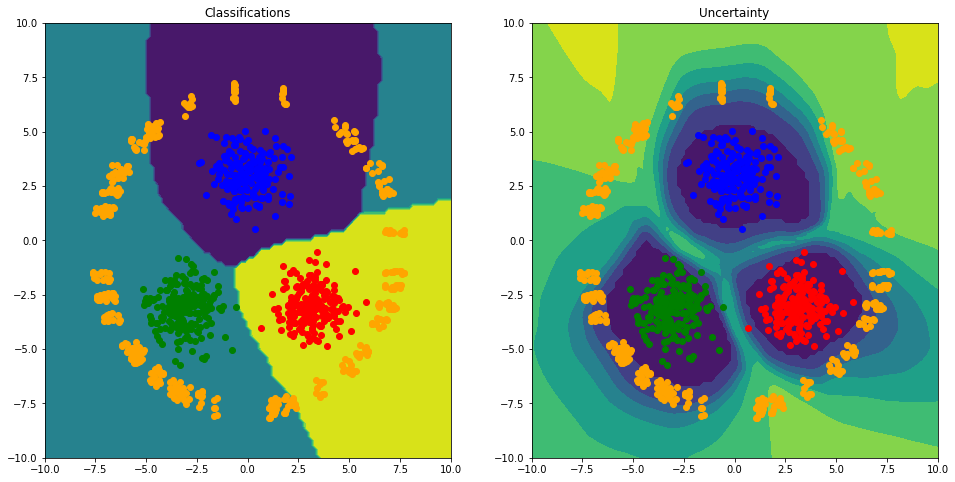

In [14]:
_,pp = plot_graphs(samples,model,[-10,10],[-10,10],aad = [0.001,0.05],p = True)